In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC,SVR
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
import os,sys
from pathlib import Path
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

dirPathJuice = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'
dirPathOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'
# dirPathOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-17-12_14_'
def regreessBehavior(choiceB,qAs,qBs,seqAB=None):
    idx=(qAs!=0)&(qBs!=0)
    if seqAB is not None:
        X = np.vstack((np.log(qBs[idx]/qAs[idx]),seqAB[idx])).T
    else:
        X = np.log(qBs[idx]/qAs[idx]).reshape(-1,1)
    y = choiceB[idx]
    model = LogisticRegression()
    model.fit(X,y)
    return model
    # return model.intercept_[0], model.coef_[0]
def getIndPoint(dirPath):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
    choiceB = np.array([0 if choiceAB[i]=='A' else 1 for i in range(len(trial_params))])
    model = regreessBehavior(choiceB,qAs,qBs)
    a0,(a1,) = model.intercept_[0], model.coef_[0]
    indPoint = np.exp(-a0/a1)
    return indPoint

def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB

def importTuningVariables(dirPath):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
    indPoint=getIndPoint(dirPath)
    valueA = qAs*indPoint
    qBs = qBs*1.0
    valueB = qBs*1.0
    choiceAB = np.array([-1 if choiceAB[i]=='A' else 1 for i in range(len(trial_params))])
    choice12 = np.array([-1 if choice12[i]=='1' else 1 for i in range(len(trial_params))])
    seqAB = np.array([(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))])
    value1 = np.array([qAs[i]*indPoint if seqAB[i]>0 else qBs[i] for i in range(len(trial_params))])
    value2 = np.array([qAs[i]*indPoint if seqAB[i]<0 else qBs[i] for i in range(len(trial_params))])
    valueA_AB = qAs.copy()*indPoint
    valueA_BA = qAs.copy()*indPoint
    valueB_AB = qBs.copy()
    valueB_BA = qBs.copy()
    valueA_AB[seqAB<0] = 0
    valueA_BA[seqAB>0] = 0
    valueB_AB[seqAB<0] = 0
    valueB_BA[seqAB>0] = 0
    valueChosen = np.array([qAs[i]*indPoint if choiceAB[i]<0 else qBs[i] for i in range(len(trial_params))])
    valueChosenA = valueChosen.copy()
    valueChosenA[choiceAB>0] = 0
    valueChosenB = valueChosen.copy()
    valueChosenB[choiceAB<0] = 0
    valueDiffAB = valueA-valueB
    valueDiff12 = value1-value2

    return seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12

def importTuningActivity(dirPath):
    import os
    with np.load(os.path.join(dirPath,'activitityTest.npz'),allow_pickle=True) as f:
        model_state = f['model_state']
    y1 = model_state[:,50:90,:].mean(axis=1)
    y2 = model_state[:,130:150,:].mean(axis=1)
    y3 = model_state[:,150:190,:].mean(axis=1)
    y4 = model_state[:,230:250,:].mean(axis=1)
    y5 = model_state[:,300:330,:].mean(axis=1)
    return y1,y2,y3,y4,y5

def generateTuningTable(Ys,xVars):
    numY = len(Ys)
    numX = len(xVars)
    y1 = Ys[0]
    N = y1.shape[-1]


    slopes = np.zeros((numY,numX,N))
    intercepts = np.zeros((numY,numX,N))
    scores = np.zeros((numY,numX,N))
    pValues = np.zeros((numY,numX,N))

    for iY,y in enumerate(Ys):
        for iX,var in enumerate(xVars):
            y_,var_ = y[~np.isnan(var),:],var[~np.isnan(var)]
            for i in range(N):
                model = LinearRegression().fit(var_.reshape(-1,1),y_[:,i])
                slopes[iY,iX,i] = model.coef_
                intercepts[iY,iX,i] = model.intercept_
                scores[iY,iX,i] = model.score(var_.reshape(-1,1),y_[:,i])
                f,pValues[iY,iX,i] = f_regression(var_.reshape(-1,1),y_[:,i])
    
    return slopes,intercepts,pValues,scores

def generateBestFit(pValues,scores):
    numY,numX,N = scores.shape
    pP = 0.001
    allTable = np.sum(pValues<pP,axis=-1)
    scores[pValues<pP] = 0
    BestFit = np.zeros((numY,N),dtype=int)
    for i in range(N):
        for iY in range(numY):
            BestFit[iY,i] = np.argmax(scores[iY,:,i])

    BestFitTable = np.zeros((numY,numX),dtype=int)
    for iY in range(numY):
        BestFitTable[iY,:],_ = np.histogram(BestFit[iY,:],bins=np.arange(0,numX+1))
    return allTable,BestFit,BestFitTable

def plotTuning(ax,x,y,color,label,marker='o',linestyle='-'):
    model = LinearRegression().fit(x.reshape(-1,1),y)
    ax.scatter(x,y,color=color,marker=marker,label=label)
    ax.plot(x,model.predict(x.reshape(-1,1)),color=color,linestyle=linestyle)

def plotCondition(ax,yC,color,label,linestyle='-'):
    ax.fill_between(np.arange(yC.shape[1]),
                    yC.mean(axis=0)-yC.std(axis=0),
                    yC.mean(axis=0)+yC.std(axis=0),
                    color=color,alpha=0.3,
                    )
    ax.plot(np.arange(yC.shape[1]),yC.mean(axis=0),
                # yerr = yC.std(axis=0),
                color=color,label=label,linestyle=linestyle)
def plotSingleUnitOffer1(ax,iCell,dirPath):

    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(
        dirPath=dirPath,
        activityFileName='activitityTest.npz')

    yToPlot = model_state[:,:,iCell]

    uniqueA = np.unique(qAs[seqAB=='AB'])
    uniqueB = np.unique(qBs[seqAB=='BA'])
    nA = len(uniqueA)
    nB = len(uniqueB)
    colorA = plt.get_cmap('Oranges',nA)
    colorB = plt.get_cmap('Blues',nB)

    for iA in range(nA):
        q = uniqueA[iA]
        color = colorA(iA)
        yC = yToPlot[(seqAB=='AB')&(qAs==q),:]
        label = f'offer1 = {q}A'
        plotCondition(ax,yC,color,label)
    for iB in range(nB):
        q = uniqueB[iB]
        color = colorB(iB)
        yC = yToPlot[(seqAB=='BA')&(qBs==q),:]
        label = f'offer1 = {q}B'
        plotCondition(ax,yC,color,label)

    ax.set_xlim((40,160))
    ax.set_xticks([50,100,150])
    ax.set_xticklabels(['1on','1off','2on'])
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
def plotSingleUnitOffer2(ax,iCell,dirPath):

    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(
        dirPath=dirPath,
        activityFileName='activitityTest.npz')

    yToPlot = model_state[:,:,iCell]

    uniqueA = np.unique(qAs[seqAB=='BA'])
    uniqueB = np.unique(qBs[seqAB=='AB'])
    nA = len(uniqueA)
    nB = len(uniqueB)
    colorB = plt.get_cmap('Oranges',nA)
    colorA = plt.get_cmap('Blues',nB)

    for iA in range(nA):
        q = uniqueA[iA]
        color = colorA(iA)
        yC = yToPlot[(seqAB=='BA')&(qAs==q),:]
        label = f'offer2 = {q}A'
        plotCondition(ax,yC,color,label)
    for iB in range(nB):
        q = uniqueB[iB]
        color = colorB(iB)
        yC = yToPlot[(seqAB=='AB')&(qBs==q),:]
        label = f'offer2 = {q}B'
        plotCondition(ax,yC,color,label)

    ax.set_xlim((140,260))
    ax.set_xticks([150,200,250])
    ax.set_xticklabels(['2on','2off','target'])
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

def plotSingleUnitChoice(ax,iCell,dirPath):

    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(
        dirPath=dirPath,
        activityFileName='activitityTest.npz')

    yToPlot = model_state[:,:,iCell]


    colorA = 'tab:orange'
    colorB = 'tab:blue'


    label = f'AB choose A'
    color = colorA
    yC = yToPlot[(seqAB=='AB')&(choiceAB=='A'),:]
    plotCondition(ax,yC,color,label,linestyle='-')
    label = f'AB choose B'
    color = colorA
    yC = yToPlot[(seqAB=='AB')&(choiceAB=='B'),:]
    plotCondition(ax,yC,color,label,linestyle='--')
    label = f'BA choose A'
    color = colorB
    yC = yToPlot[(seqAB=='BA')&(choiceAB=='A'),:]
    plotCondition(ax,yC,color,label,linestyle='-')
    label = f'BA choose B'
    color = colorB
    yC = yToPlot[(seqAB=='BA')&(choiceAB=='B'),:]
    plotCondition(ax,yC,color,label,linestyle='--')

    ax.set_xlim((140,310))
    ax.set_xticks([150,200,250,300])
    ax.set_xticklabels(['2on','2off','target','action'])
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


def plotTuningMatrix(iCell,dirPath,frame='juice'):
    y1,y2,y3,y4,y5 = importTuningActivity(dirPath)
    seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)
    
    colorA = "tab:orange"
    colorAs = plt.get_cmap('Oranges',7)
    colorB = "tab:blue"
    colorBs = plt.get_cmap('Blues',9)

    fig,axes = plt.subplots(ncols=5,nrows=3,figsize=(20,10),dpi=150,constrained_layout=True)
    
    ax = axes[0,0]
    x = valueA_AB[valueA_AB!=0]
    y = y1[valueA_AB!=0,iCell]
    plotTuning(ax,x,y,colorA,label='AB trial')
    x = valueB_BA[valueB_BA!=0]
    y = y1[valueB_BA!=0,iCell]
    plotTuning(ax,x,y,colorB,label='BA trial')
    ax.set_xlabel('value 1')
    ax.set_ylabel('post_offer1')
    ax.legend()

    ax = axes[0,1]
    x = valueA_AB[valueA_AB!=0]
    y = y2[valueA_AB!=0,iCell]
    plotTuning(ax,x,y,colorA,label='AB trial')
    x = valueB_BA[valueB_BA!=0]
    y = y2[valueB_BA!=0,iCell]
    plotTuning(ax,x,y,colorB,label='BA trial')
    ax.set_xlabel('value 1')
    ax.set_ylabel('pre_offer2')
    ax.legend()

    ax = axes[0,2]
    x = valueA_BA[valueA_BA!=0]
    y = y3[valueA_BA!=0,iCell]
    plotTuning(ax,x,y,colorA,label='BA trial')
    x = valueB_BA[valueB_BA!=0]
    y = y3[valueB_BA!=0,iCell]
    plotTuning(ax,x,y,colorB,label='AB trial')
    ax.set_xlabel('value 2')
    ax.set_ylabel('post_offer2')
    ax.legend()

    ax = axes[0,3]
    x = valueA_BA[valueA_BA!=0]
    y = y4[valueA_BA!=0,iCell]
    plotTuning(ax,x,y,colorA,label='BA trial')
    x = valueB_BA[valueB_BA!=0]
    y = y4[valueB_BA!=0,iCell]
    plotTuning(ax,x,y,colorB,label='AB trial')
    ax.set_xlabel('value 2')
    ax.set_ylabel('pre_target')
    ax.legend()

    axes[0,4].set_axis_off()
    axes[1,0].set_axis_off()
    axes[1,1].set_axis_off()

    for iCol,yi,ylabel in zip([2,3,4],[y3,y4,y5],['post_offer2','pre_target','action']):
        ax = axes[1,iCol]
        if frame=='juice':
            x = valueChosenA[valueChosenA!=0]
            y = yi[valueChosenA!=0,iCell]
            plotTuning(ax,x,y,colorA,label='choose A')
            x = valueChosenB.copy()[valueChosenB!=0]
            y = yi[valueChosenB!=0,iCell]
            plotTuning(ax,x,y,colorB,label='choose B')
        elif frame=='order':
            x = valueChosen[(choice12<0)&(valueChosen!=0)]
            y = yi[(choice12<0)&(valueChosen!=0),iCell]
            plotTuning(ax,x,y,'k',marker='+',linestyle='--',label='choose 1')
            x = valueChosen[(choice12>0)&(valueChosen!=0)]
            y = yi[(choice12>0)&(valueChosen!=0),iCell]
            plotTuning(ax,x,y,'k',marker='o',label='choose 1')

        ax.set_xlabel('value chosen')
        ax.set_ylabel(ylabel)
        ax.legend()
    
    axes[2,0].set_axis_off()
    axes[2,1].set_axis_off()

    for iCol,yi,ylabel in zip([2,3,4],[y3,y4,y5],['post_offer2','pre_target','action']):
        ax = axes[2,iCol]
        x = valueDiffAB
        y = yi[:,iCell]
        plotTuning(ax,x,y,'r',label='valueA-valueB')
        x = valueDiff12
        plotTuning(ax,x,y,'g',label='value1-value2')
        ax.set_xlabel('value difference')
        ax.set_ylabel(ylabel)
        ax.legend()

    ax=axes[1,0]
    ax.set_title('offer1',loc='left')
    plotSingleUnitOffer1(ax,iCell,dirPath)
    ax=axes[1,1]
    ax.set_title('offer2',loc='left')
    plotSingleUnitOffer2(ax,iCell,dirPath)
    ax=axes[2,1]
    ax.set_title('choice',loc='left')
    plotSingleUnitChoice(ax,iCell,dirPath)
    for ax in (axes[1,0],axes[1,1],axes[2,1]):
        ax.set_axis_on()
        ax.get_yaxis().set_visible(False)
        ax.spines[['top','right','left']].set_visible(False)
    
    return fig



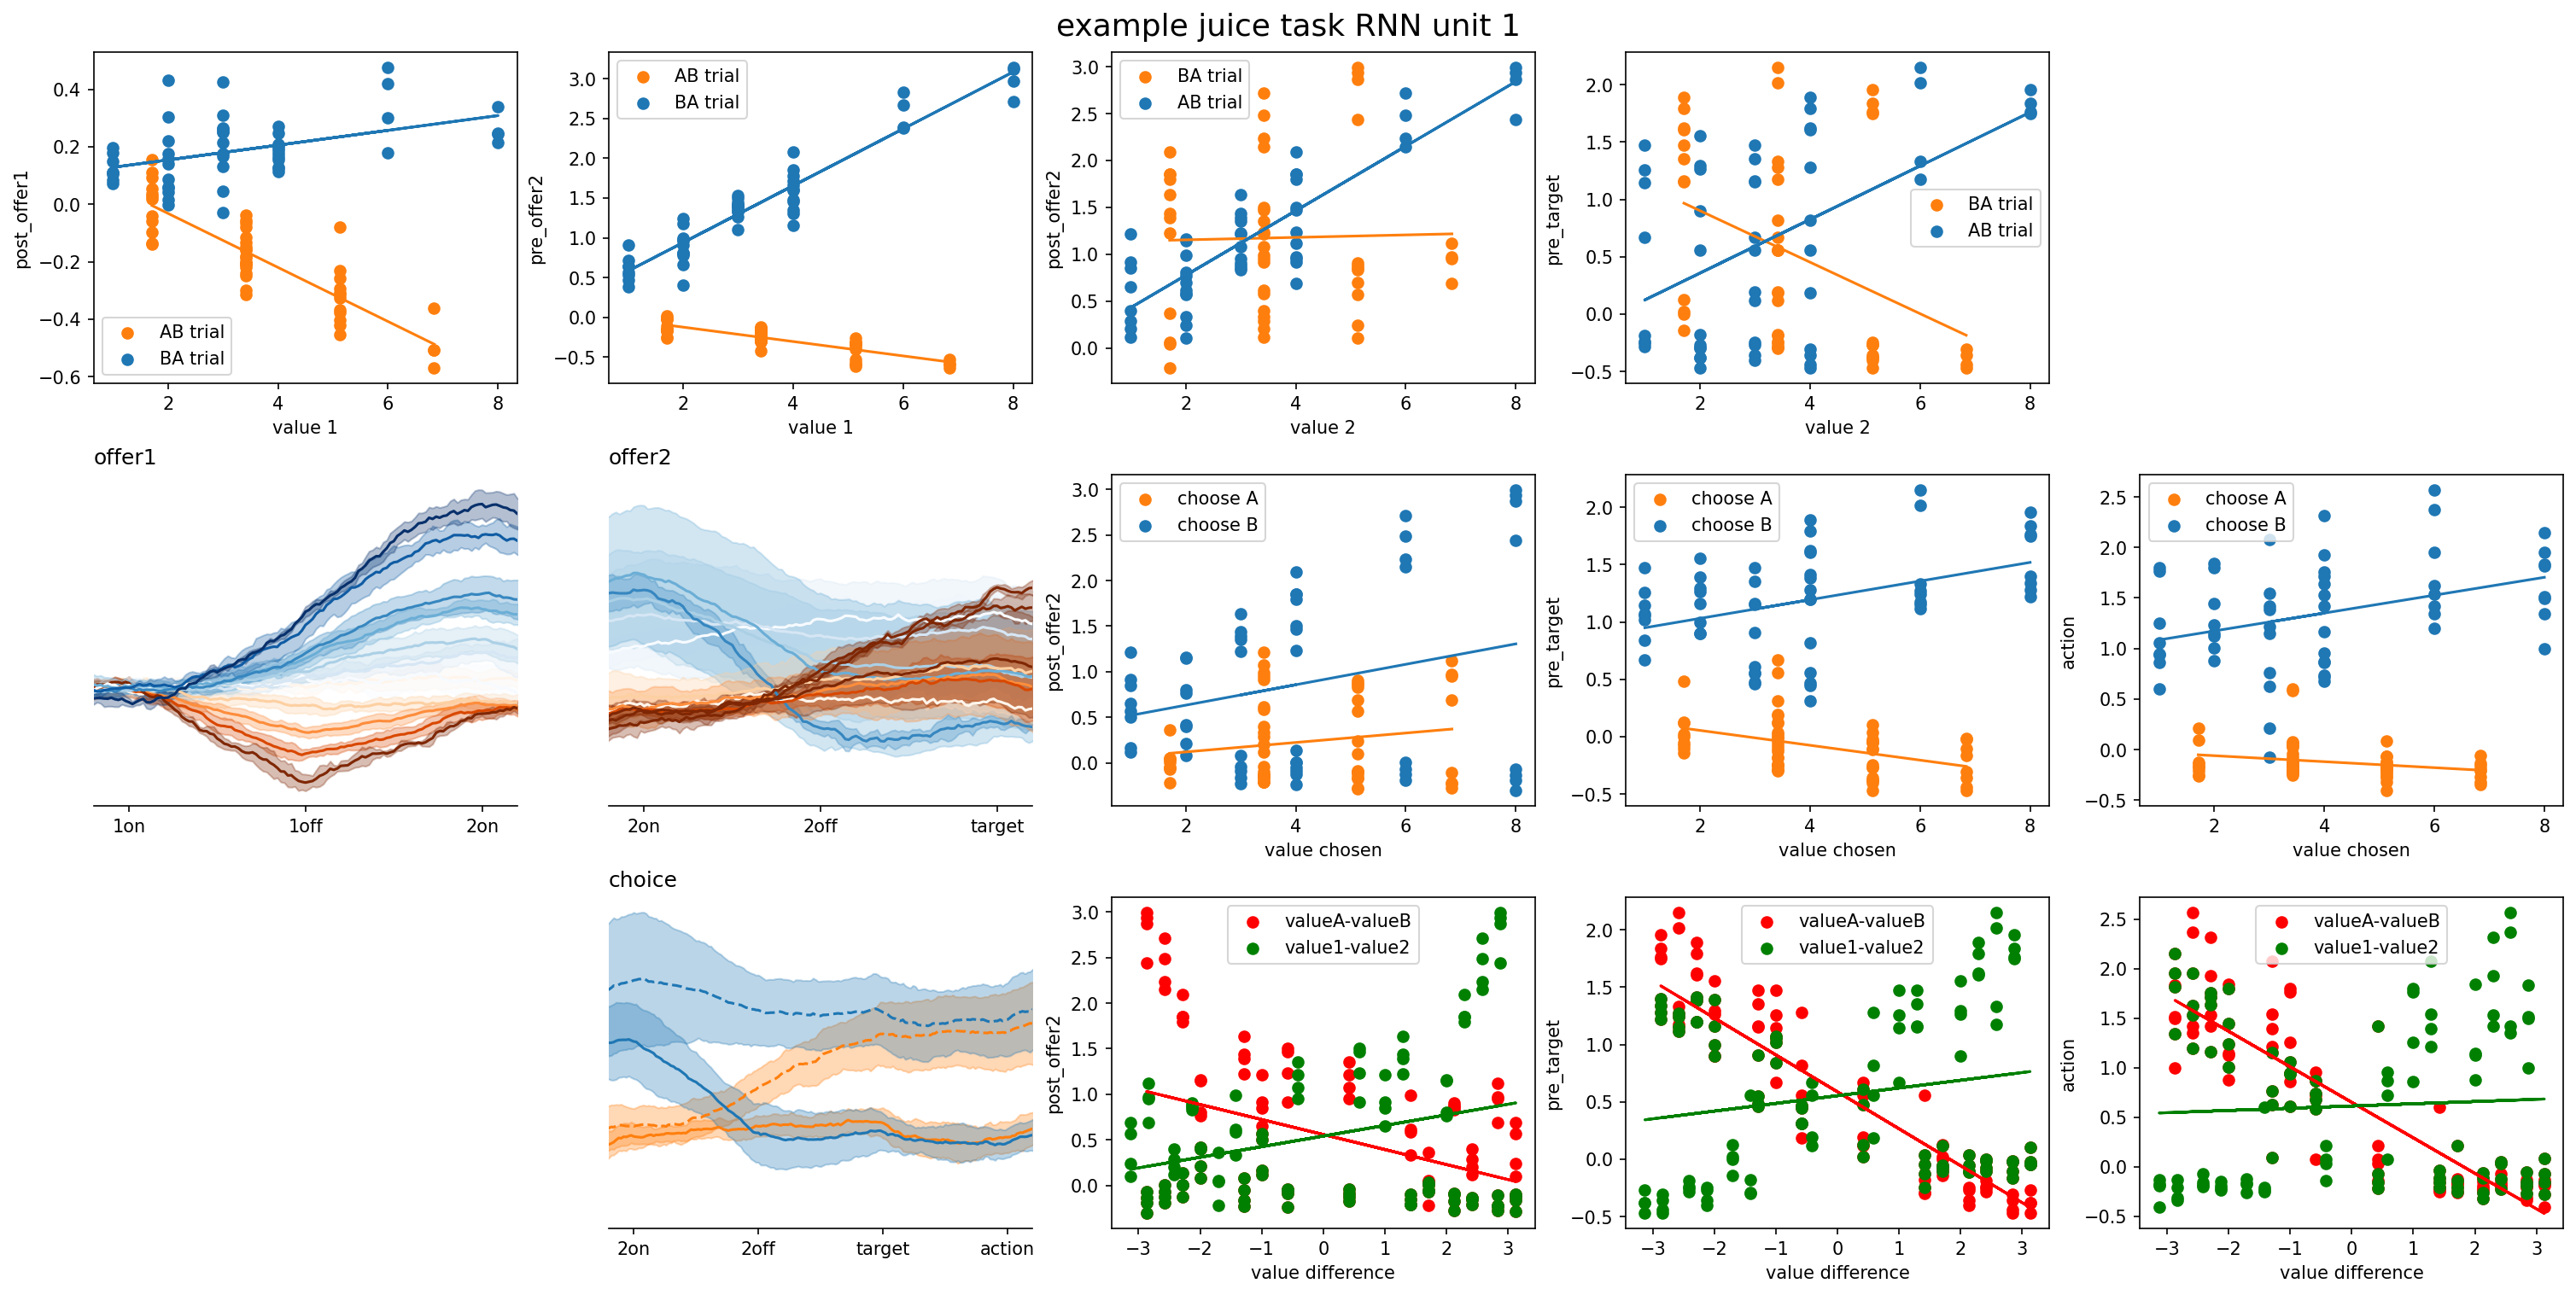

In [9]:
iCell=0
fig=plotTuningMatrix(iCell,dirPathJuice,frame='juice')
fig.suptitle(f'example juice task RNN unit {iCell+1}',size='xx-large')
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig2/juiceNeuron1.pdf')

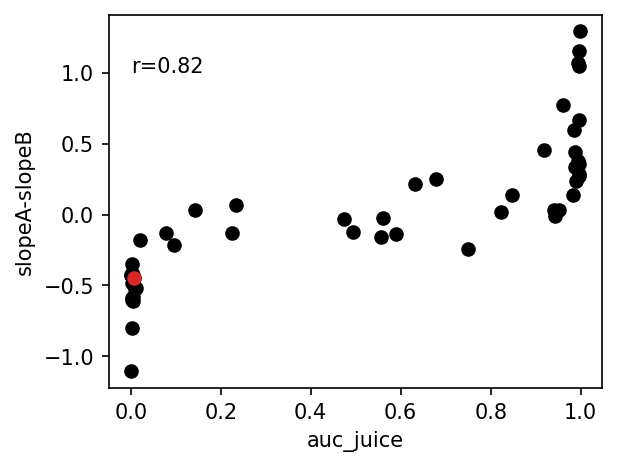

In [10]:
dirPath = dirPathJuice
y1,y2,y3,y4,y5 = importTuningActivity(dirPath)
seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)
N = y1.shape[1]

auc_order = np.array([roc_auc_score(choice12,y4[:,i]) for i in range(N)])
auc_juice = np.array([roc_auc_score(-choiceAB,y4[:,i]) for i in range(N)])

x = value1[value1!=0]
model = LinearRegression().fit(x.reshape(-1,1),y2[value1!=0])
slope1 = model.coef_
x = valueA_AB[valueA_AB!=0]
model = LinearRegression().fit(x.reshape(-1,1),y2[valueA_AB!=0])
slopeA = model.coef_[:,0]
x = valueB_BA[valueB_BA!=0]
model = LinearRegression().fit(x.reshape(-1,1),y2[valueB_BA!=0])
slopeB = model.coef_[:,0]

fig,ax = plt.subplots(dpi=150,figsize=(4,3),constrained_layout=True)
ax.scatter(auc_juice,slopeA-slopeB,color='k')
# ax.plot(auc_juice, np.poly1d(np.polyfit(auc_juice, slopeA-slopeB, 1))
#          ((auc_juice)), color='k')
ax.scatter(auc_juice[iCell],(slopeA-slopeB)[iCell],color='tab:red')
ax.text(0,1,f'r={(np.corrcoef(auc_juice,slopeA-slopeB))[0,1]:.2f}')
ax.set_xlabel('auc_juice')
ax.set_ylabel('slopeA-slopeB')

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig2/JuiceOfferChoicePreference.pdf')

In [4]:
corrcoef_juice = []
dirPaths = []
dirName = 'juiceTaskDefault'
root = "/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/"+dirName
for name in os.listdir(root):
    dirPath = os.path.join(root,name)
    if os.path.isdir(dirPath):
        dirPaths.append(dirPath)
        y1,y2,y3,y4,y5 = importTuningActivity(dirPath)
        seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)
        N = y1.shape[1]

        auc_order = np.array([roc_auc_score(-choice12,y4[:,i]) for i in range(N)])
        auc_juice = np.array([roc_auc_score(-choiceAB,y4[:,i]) for i in range(N)])

        x = value1[value1!=0]
        model = LinearRegression().fit(x.reshape(-1,1),y2[value1!=0])
        slope1 = model.coef_[:,0]
        x = valueA_AB[valueA_AB!=0]
        model = LinearRegression().fit(x.reshape(-1,1),y2[valueA_AB!=0])
        slopeA = model.coef_[:,0]
        x = valueB_BA[valueB_BA!=0]
        model = LinearRegression().fit(x.reshape(-1,1),y2[valueB_BA!=0])
        slopeB = model.coef_[:,0]

        fig,ax = plt.subplots(dpi=150,figsize=(4,3),constrained_layout=True)
        ax.scatter(auc_juice,slopeA-slopeB,color='k')
        ax.text(0,1,f'r={(np.corrcoef(auc_juice,slopeA-slopeB))[0,1]:.2f}')
        ax.set_xlabel('auc_juice')
        ax.set_ylabel('slopeA-slopeB')
        fig.savefig(os.path.join(dirPath,'JuiceOfferChoicePreference.pdf'))
        corrcoef_juice.append(np.corrcoef(auc_juice,slopeA-slopeB)[0,1])
        plt.close('all')

np.save('./Figure/Fig3/corrcoef_juice',corrcoef_juice)

/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

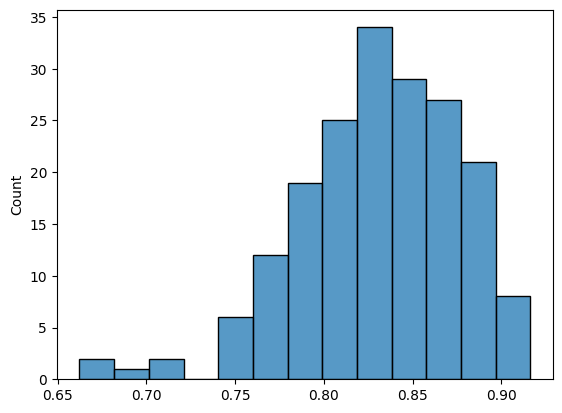

In [5]:
sns.histplot(corrcoef_juice)

Text(0.5, 0.98, 'example order task RNN unit 4')

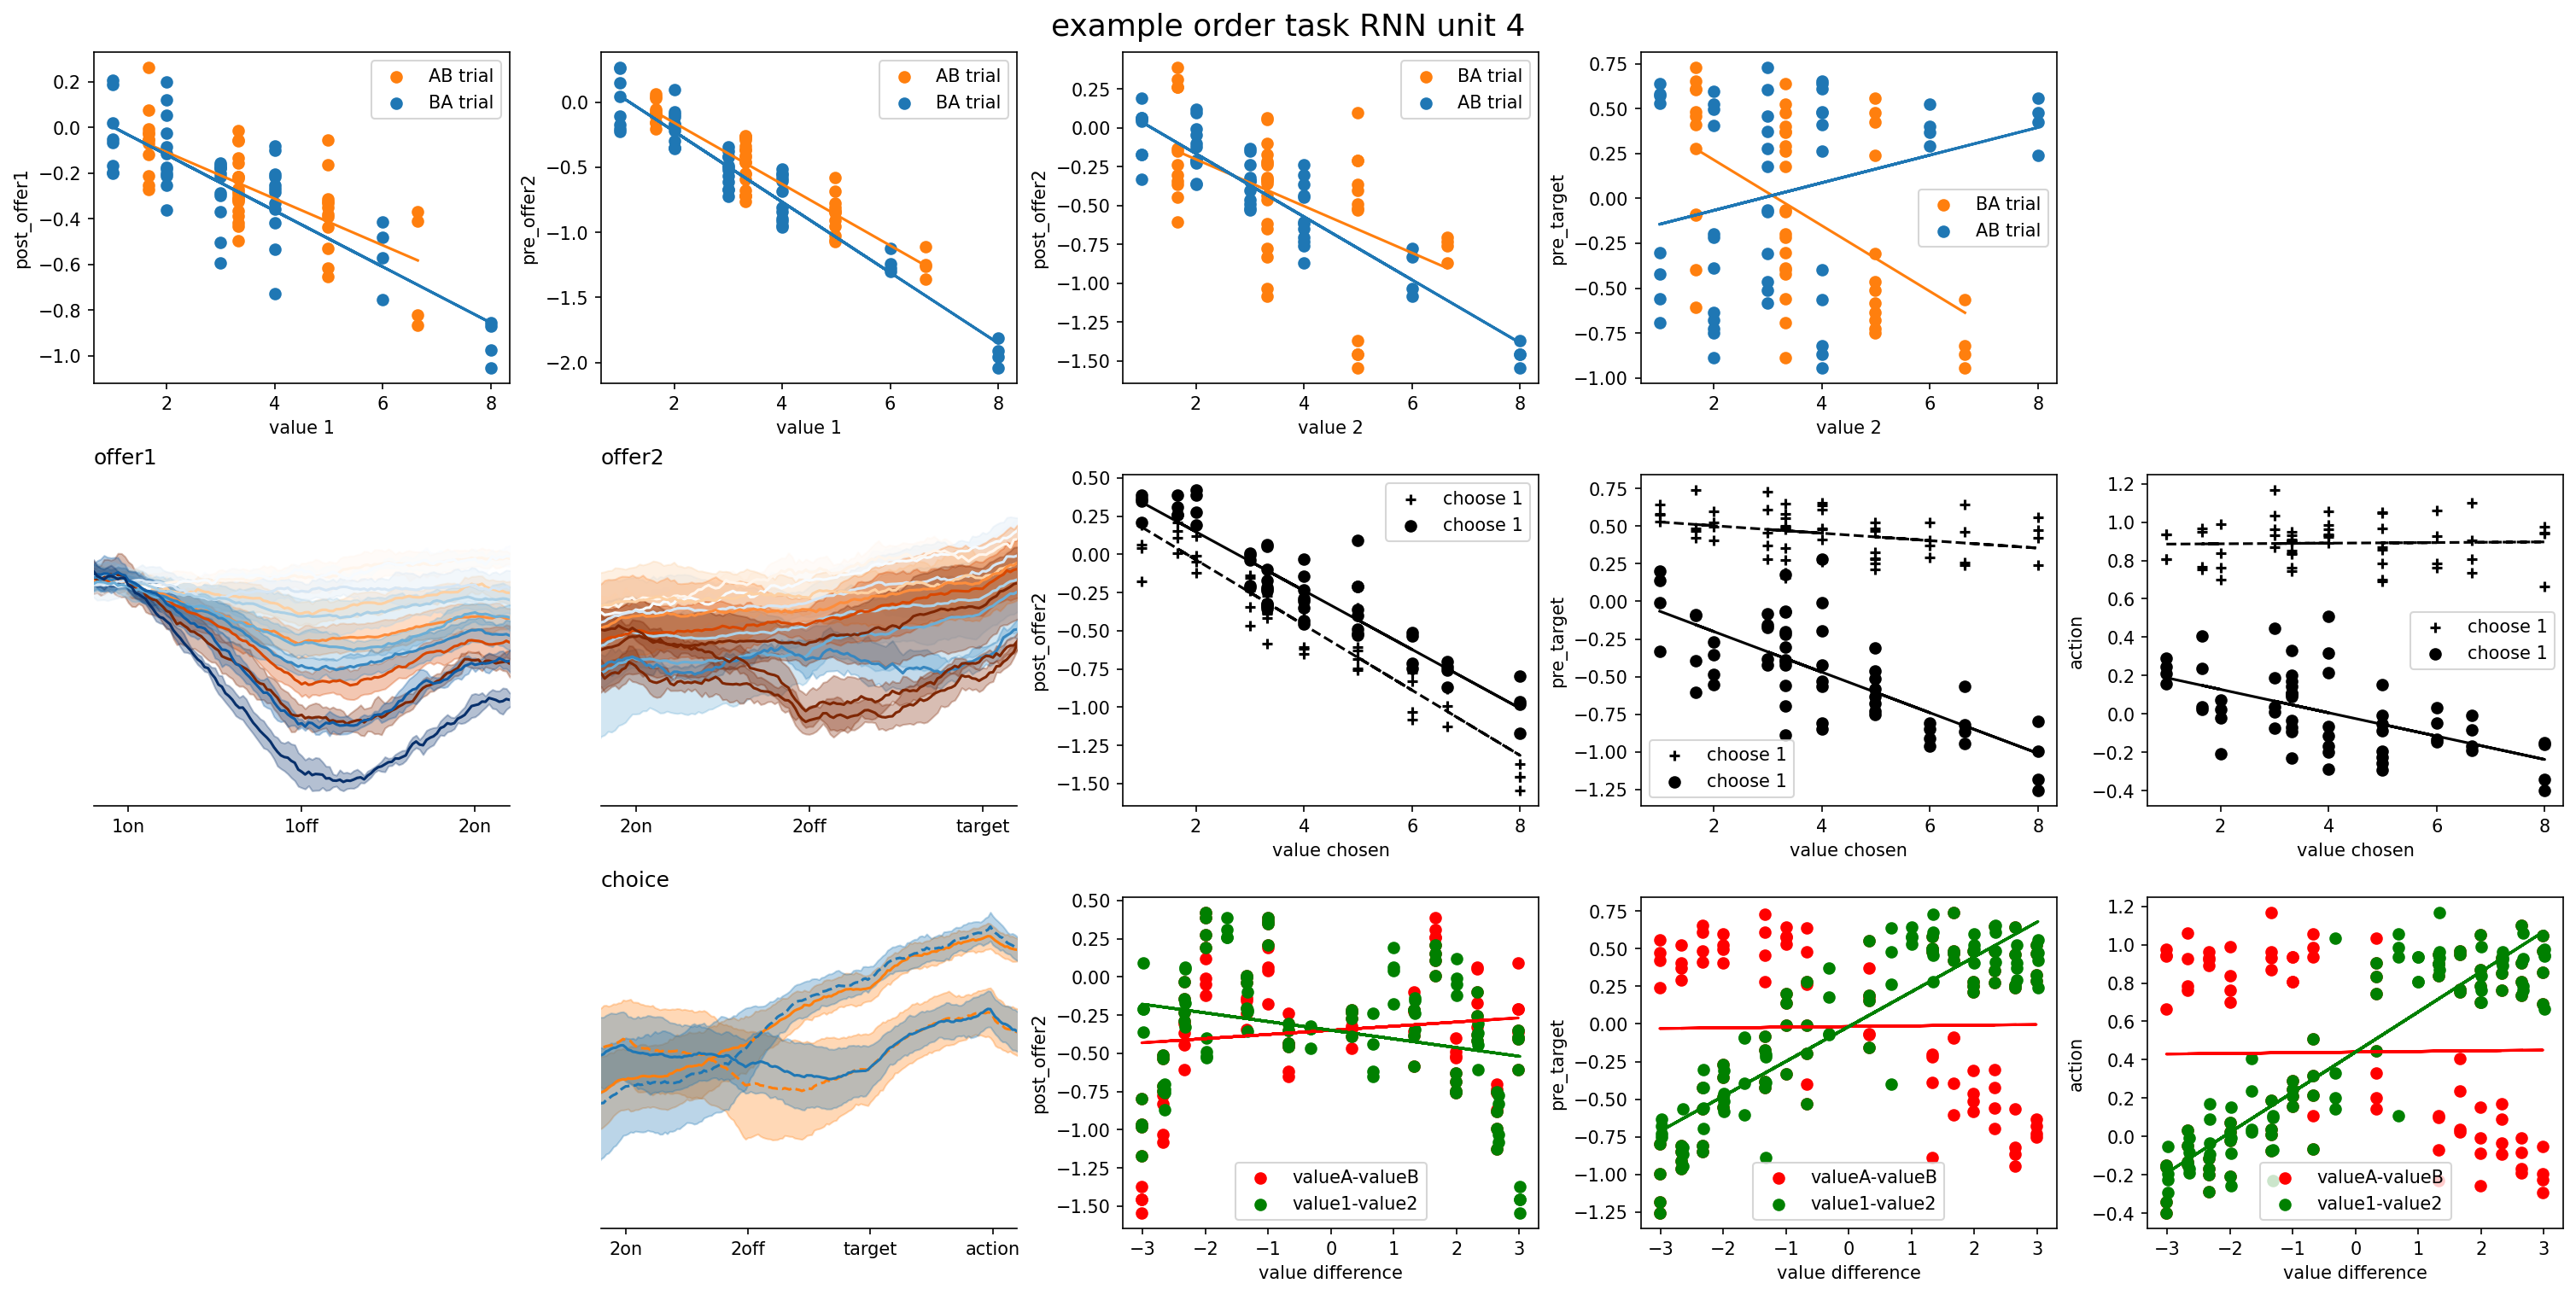

In [4]:
iCell=3
fig=plotTuningMatrix(iCell,dirPathOrder,frame='order')
fig.suptitle(f'example order task RNN unit {iCell+1}',size='xx-large')
# fig.savefig('./Figure/Fig2/OrderNeuron22.pdf')

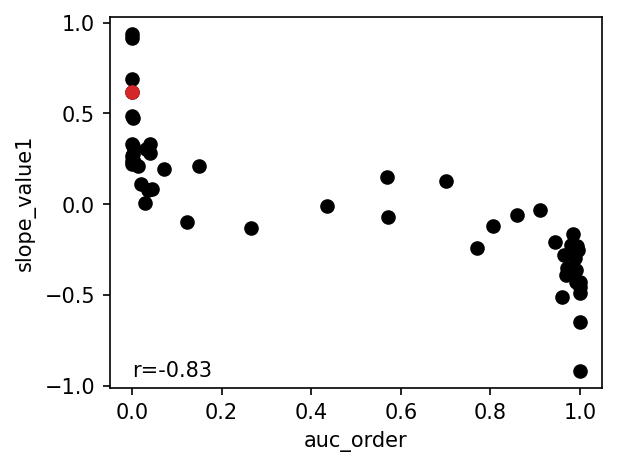

In [12]:
dirPath = dirPathOrder
y1,y2,y3,y4,y5 = importTuningActivity(dirPath)
seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)
N = y1.shape[1]

auc_order = np.array([roc_auc_score(-choice12,y4[:,i]) for i in range(N)])
auc_juice = np.array([roc_auc_score(-choiceAB,y4[:,i]) for i in range(N)])

x = value1[value1!=0]
model = LinearRegression().fit(x.reshape(-1,1),y2[value1!=0])
slope1 = model.coef_[:,0]
x = valueA_AB[valueA_AB!=0]
model = LinearRegression().fit(x.reshape(-1,1),y2[valueA_AB!=0])
slopeA = model.coef_[:,0]
x = valueB_BA[valueB_BA!=0]
model = LinearRegression().fit(x.reshape(-1,1),y2[valueB_BA!=0])
slopeB = model.coef_[:,0]

fig,ax = plt.subplots(dpi=150,figsize=(4,3),constrained_layout=True)
ax.scatter(auc_order,slope1,color='k')
ax.scatter(auc_order[iCell],slope1[iCell],color="tab:red")
ax.text(0,-0.95,f'r={(np.corrcoef(auc_order,slope1)[0,1]):.2f}')
ax.set_xlabel('auc_order')
ax.set_ylabel('slope_value1')
fig.savefig('./Figure/Fig2/OrderOfferChoicePreference.pdf')

In [ ]:
corrcoef_order = []
dirPaths = []
dirName = 'orderTaskDefault'
root = "/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/"+dirName
for name in os.listdir(root):
    dirPath = os.path.join(root,name)
    if os.path.isdir(dirPath):
        dirPaths.append(dirPath)
        y1,y2,y3,y4,y5 = importTuningActivity(dirPath)
        seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)
        N = y1.shape[1]

        auc_order = np.array([roc_auc_score(-choice12,y4[:,i]) for i in range(N)])
        auc_juice = np.array([roc_auc_score(-choiceAB,y4[:,i]) for i in range(N)])

        x = value1[value1!=0]
        model = LinearRegression().fit(x.reshape(-1,1),y2[value1!=0])
        slope1 = model.coef_[:,0]
        x = valueA_AB[valueA_AB!=0]
        model = LinearRegression().fit(x.reshape(-1,1),y2[valueA_AB!=0])
        slopeA = model.coef_[:,0]
        x = valueB_BA[valueB_BA!=0]
        model = LinearRegression().fit(x.reshape(-1,1),y2[valueB_BA!=0])
        slopeB = model.coef_[:,0]

        fig,ax = plt.subplots(dpi=150,figsize=(4,3),constrained_layout=True)
        ax.scatter(auc_order,slope1,color='k')
        ax.text(0,-0.95,f'r={(np.corrcoef(auc_order,slope1)[0,1]):.2f}')
        ax.set_xlabel('auc_order')
        ax.set_ylabel('slope_value1')
        fig.savefig(os.path.join(dirPath,'OrderOfferChoicePreference.pdf'))
        corrcoef_order.append(np.corrcoef(auc_order,slope1)[0,1])
        plt.close('all')

np.save('./Figure/Fig3/corrcoef_order',corrcoef_order)

/gpfsnyu/home/jtg374/.conda/envs/torch_sklearn_dsa/lib/python3.10/site-packages/seaborn/_oldcore.py:1120: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

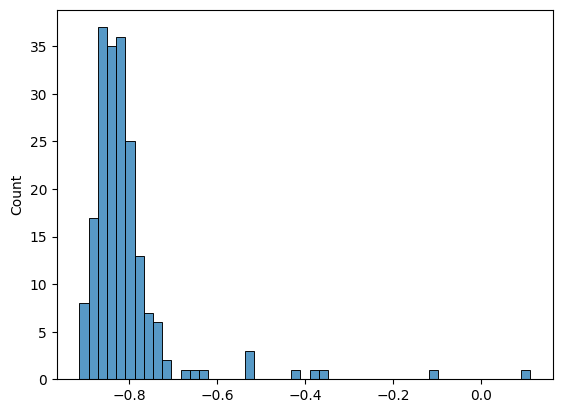

In [6]:
import seaborn as sns
sns.histplot(corrcoef_order)

In [10]:
print(np.nonzero(np.array(corrcoef_order)>-0.6))
corrcoef_order = np.array(corrcoef_order)
dirPaths = np.array(dirPaths)
print(dirPaths[corrcoef_order>-0.6])

(array([  8,  53,  64,  93, 121, 178, 180, 183]),)
['/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231220-10-12_9_juiceRep_badChoice'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20240516-05-05_31_'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231226-18-12_6_'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231220-02-12_0_'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20240429-18-04_12_Fail'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20240411-17-04_18_condenseHighValAgainQ'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20240515-20-05_8_'
 '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231220-04-12_2_']


In [11]:
print(dirPaths[corrcoef_order>-0
               ])

['/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20240516-05-05_31_']
